# Preliminaries

In [1]:
!pip install astroquery

     |████████████████████████████████| 4.5MB 2.8MB/s 
     |████████████████████████████████| 2.7MB 44.8MB/s 
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=84a88a5e18d3277065ce5d3f008160bd4e709a7f2cc30b1cf041616d6565c15f
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
Successfully built astroquery



[Catalog of sources](https://cdsarc.unistra.fr/viz-bin/cat/J/A%2bA/628/A66)

Not sure how to render this:
```
@MISC{ vizier:J/A+A/628/A66, 
author = {Lodieu N., Perez-Garrido A., Smart R.L., Silvotti, R.}, 
title = "{VizieR Online Data Catalog: alpha Persei, Pleiades and Praesepe clusters}", 
year = "2019", 
doi = {10.26093/cds/vizier.36280066}, 
journal = {\aap}
}
```

In [20]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import astropy.coordinates as coord
from astropy.table import QTable, vstack

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import pandas as pd
import pickle
import os

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

# Get Lodieu Data Files

Details of processing these data files are [here](https://drive.google.com/file/d/1-BXGwshTcOD1bptRXy_pKGCemQnDY22z/view?usp=sharing)


In [0]:
root_dir = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66'
# column definition
path = os.path.join(root_dir, 'alpha_per_definition.pkl')
with open(path,'rb') as pkl:
  alpha_per_coldefs = pickle.load(pkl)

# data file  
path = os.path.join(root_dir, 'alphaper.pkl')
with open(path,'rb') as pkl:
  alpha_per = pickle.load(pkl)

In [6]:
alpha_per.head()

,RAdeg,DEdeg,SourceCP,RVCP,e_RVCP,PlxCP,e_PlxCP,GmagCP,pmRACP,e_pmRACP,pmDECP,e_pmDECP,bx,by,bz,vx,vy,vz,c,distC,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,...,chi2AL,epsi,sepsi,Solved,APF,WAL,pscol,e_pscol,fvarpi,MatchObsA,Nper,amax,MatchObs,Dup,o_Gmag,FG,e_FG,RFG,Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,E(BR/RP),Mode,RV,e_RV,o_RV,rest,b_rest,B_rest,rlen,ResFlag,ModFlag
0,34.813290,52.493074,455075360092433920,-9999.0,-9999.0,5.77091,0.109942,16.5334,27.646,0.350,-19.901,0.181,-123.872,118.688,-24.409,-9999.0,-9999.0,-9999.0,0.420957,34.5058,455075360092433920,5.7999,0.1099,27.646,0.350,-19.901,0.181,-0.2699,-0.5139,-0.8077,0.4042,0.0562,0.3804,-0.1491,0.5416,-0.1116,-0.3220,141,0,141,...,207.98,0.281,2.61,31,0,3.4993,1.2448,0.0191,-0.114,16,10,0.339762,19,0,166,4592.00,4.7807,960.526,16.5334,15,615.380,10.6550,57.758,18.378500,18,6480.10,18.5470,349.383,15.233000,1.545,0,0.0,0.0,0,171.669,168.464,174.996,827.580,1,1
1,35.010252,52.664085,455037048980464896,-9999.0,-9999.0,5.63410,1.095480,20.3099,18.664,2.195,-20.069,1.896,-127.060,121.507,-24.384,-9999.0,-9999.0,-9999.0,13.234600,34.3879,455037048980464896,5.6581,1.0955,18.664,2.195,-20.069,1.896,0.2736,-0.4405,-0.6056,-0.0620,-0.1343,-0.0219,0.3494,0.3507,0.3873,0.2143,115,0,113,...,123.82,1.942,2.12,31,0,0.0436,1.7967,0.2023,-0.008,14,9,2.102480,17,0,139,141.71,1.0618,133.458,20.3099,9,28.670,10.6950,2.681,21.707800,16,234.81,9.2633,25.348,18.835100,1.859,0,0.0,0.0,0,189.235,149.916,256.777,834.032,1,1
2,35.076013,52.480215,455026156947855872,-9999.0,-9999.0,5.46087,1.454370,20.3340,21.394,3.404,-2.636,2.976,-131.260,125.082,-25.662,-9999.0,-9999.0,-9999.0,12.647600,35.1074,455026156947855872,5.4758,1.4544,21.394,3.404,-2.636,2.976,0.3917,-0.0868,-0.5967,-0.1674,0.0537,-0.2249,-0.2459,0.2538,0.2781,0.2142,98,0,98,...,262.85,5.371,10.10,31,0,0.0186,1.3558,0.3260,-0.009,11,9,3.279610,15,1,125,138.59,1.3518,102.525,20.3340,11,51.996,5.1588,10.079,21.061501,14,188.02,18.8130,9.994,19.076401,1.732,0,0.0,0.0,0,211.700,126.050,725.565,828.804,1,1
3,35.095645,48.516677,355242590505237888,-9999.0,-9999.0,5.89340,0.077502,15.8404,27.676,0.134,-19.837,0.128,-122.993,111.648,-34.630,-9999.0,-9999.0,-9999.0,0.767255,33.9603,355242590505237888,5.9488,0.0775,27.676,0.134,-19.837,0.128,0.1752,0.2034,-0.5221,0.0501,-0.2183,-0.0538,-0.2104,0.0859,0.3614,0.1999,195,0,195,...,353.91,0.300,6.64,31,0,5.2357,1.2836,0.0156,-0.002,22,11,0.134695,24,0,213,8693.70,9.2816,936.664,15.8404,22,1552.200,10.2840,150.926,17.374001,22,11301.00,36.1090,312.962,14.629200,1.478,0,0.0,0.0,0,167.334,165.175,169.549,686.124,1,1
4,35.202351,49.437643,355343947436467200,-9999.0,-9999.0,5.82667,0.286555,17.6887,36.234,0.626,-24.237,0.433,-124.281,113.835,-32.416,-9999.0,-9999.0,-9999.0,19.325500,33.2344,355343947436467200,5.8477,0.2866,36.234,0.626,-24.237,0.433,-0.0121,-0.0533,-0.6749,0.1690,-0.1872,0.1828,0.0101,0.1676,0.2505,0.0145,143,0,143,...,512.20,1.149,14.90,31,0,0.4716,1.3067,0.0562,-0.038,17,10,0.575591,19,0,156,1584.40,7.5617,209.534,17.6887,13,341.910,10.0650,33.970,19.016600,12,2415.60,14.7320,163.971,16.304399,1.740,1,0.0,0.0,0,170.884,162.705,179.914,721.461,1,1


In [7]:
len(alpha_per)

3162

In [8]:
alpha_per_coldefs['distC']

{'desc': 'Distance from the center of the cluster (dist_center)',
 'units': 'pc'}

In [9]:
alpha_per_coldefs['bx']

{'desc': 'Galactic X coordinate (b_x)', 'units': 'pc'}

In [0]:
import re
def find_columns(what, defs=alpha_per_coldefs):
  target = '.*' + what + '.*'
  cols =   ['{0}: {1}'.format(c, defs[c]['desc'])for c in alpha_per_coldefs if re.match(target,defs[c]['desc'],flags=re.IGNORECASE)]
  return cols

In [11]:
find_columns('parallax')

['PlxCP: Parallax (Plx_CP)',
 'e_PlxCP: Parallax error (ePlx_CP)',
 'Plx: Gaia DR2 parallax (parallax)',
 'e_Plx: Gaia DR2 parallax error (parallax_error)',
 'RAPlxcor: ? Correlation between right ascension and parallax (ra_parallax_corr)',
 'DEPlxcor: ? Correlation between declination and parallax (dec_parallax_corr)',
 'PlxpmRAcor: ? Correlation between parallax and proper motion in right ascension (parallax_pmra_corr)',
 'PlxpmDEcor: ? Correlation between parallax and proper motion in declination (parallax_pmdec_corr)',
 'fvarpi: Mean Parallax factor AL (mean_varpi_factor_al)']

### Cut the data by distance from Cluster Center

In [0]:
cuts = np.array([0,2.3,5.6, 9.5, 28.5,50,75,100])
labs = [f'Within {d} pc' for d in cuts[1:]]
#sm = cm.ScalarMappable(cmap=cm.Set1)
#bin_colors = sm.to_rgba(range(len(labs)), alpha=0.8)
bin_colors = ['black', 'blue', 'green', 'red','magenta','orange', 'yellow']
alpha_per['DistanceBin'] = cutd =pd.cut(alpha_per.distC, cuts, labels=labs)


In [13]:
alpha_per.DistanceBin.value_counts()

Within 28.5 pc     1552
Within 50.0 pc     1060
Within 9.5 pc       293
Within 5.6 pc       201
Within 2.3 pc        23
Within 75.0 pc        9
Within 100.0 pc       4
Name: DistanceBin, dtype: int64

# Lodieu Plots

The plots below reproduce Figure A.1 in Appendix A of Lodieu's paper. Not all of the 3,162 objects in the data file are plotted, just the 2,069 objects within 28.5 parsecs of $\alpha Per$ center in keeping with the Lodieu's methodology.

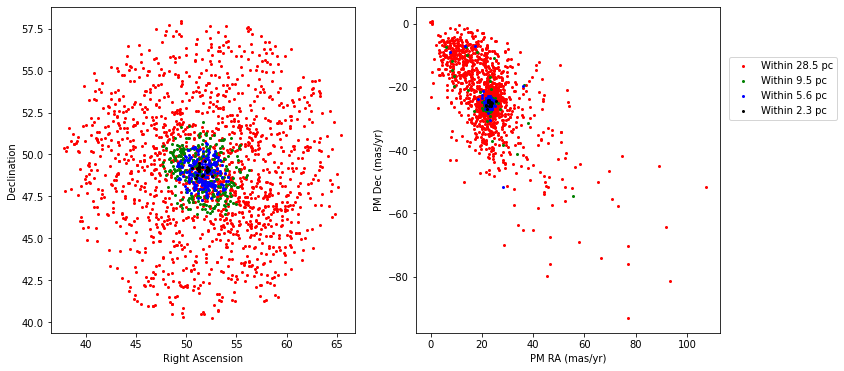

In [14]:
#@title RA, Dec, and PM

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(3,-1,-1):
  pdf = alpha_per.query('DistanceBin == @labs[@i]')
  ax[0].scatter(pdf.RAdeg, pdf.DEdeg, color=bin_colors[i], label=labs[i], s=4)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for i in range(3,-1,-1):
  pdf = alpha_per.query('DistanceBin == @labs[@i]')
  ax[1].scatter(pdf.pmRA, pdf.pmDE, color=bin_colors[i], label=labs[i], s=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')


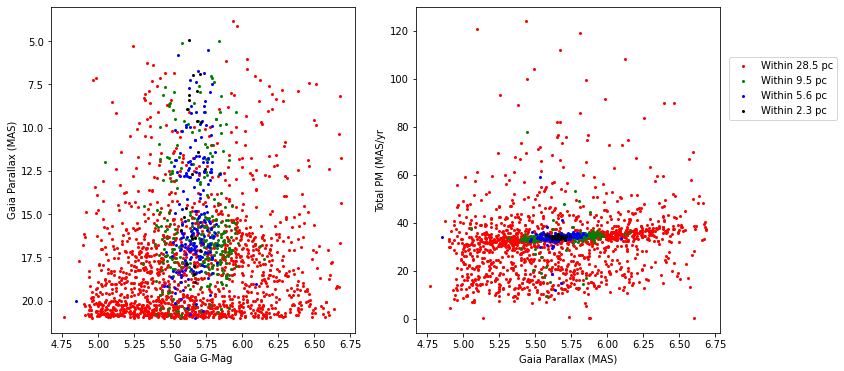

In [15]:
#@title Magnitude and PM v. Parallax

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(3,-1,-1):
  pdf = alpha_per.query('DistanceBin == @labs[@i]')
  ax[0].scatter(pdf.Plx, pdf.Gmag, color=bin_colors[i], label=labs[i], s=4)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Gaia G-Mag')
ax[0].invert_yaxis()
_=ax[0].set_ylabel('Gaia Parallax (MAS)')

for i in range(3,-1,-1):
  pdf = alpha_per.query('DistanceBin == @labs[@i]')
  ax[1].scatter(pdf.Plx,
                np.sqrt(pdf.pmRA**2 + pdf.pmDE**2),
                 color=bin_colors[i], label=labs[i], s=4)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_ylabel('Total PM (MAS/yr')
_=ax[1].set_xlabel('Gaia Parallax (MAS)')

Text(0.5, 1.0, 'Count by Distance Bin')

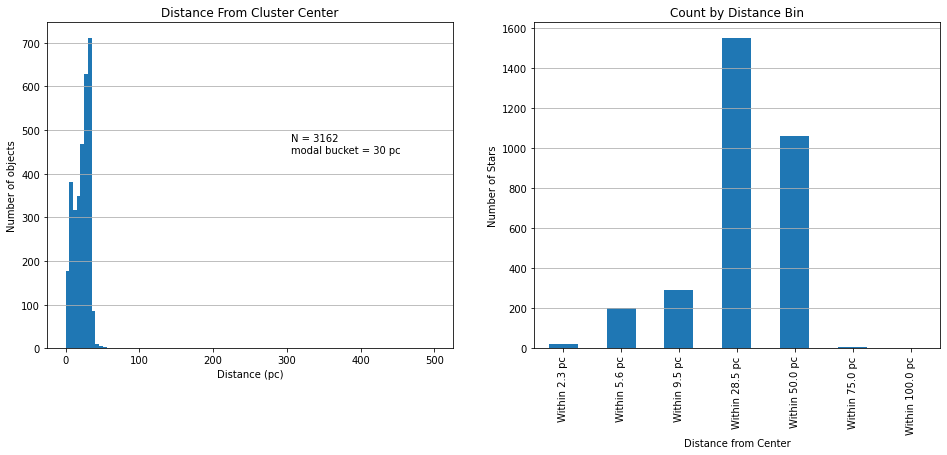

In [16]:
#@title Distance from Center Histograms
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
zz=ax[0].hist(alpha_per.distC, bins=np.linspace(0,500,100, endpoint=True))
ax[0].set_ylabel('Number of objects')
un = u.parsec
ax[0].set_xlabel(f'Distance ({un})')
ax[0].set_title('Distance From Cluster Center')
N = len(alpha_per)
mode = zz[1][zz[0].argmax()]
ax[0].text(0.60, 0.60,f'N = {N}\nmodal bucket = {mode:.0f} pc',transform=ax[0].transAxes)
ax[0].grid(axis='y')
#ax.axvline(alf_per_dist, color='red',label=r'$\alpha Per$')
#ax.legend()

alpha_per.groupby('DistanceBin').size().plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('Number of Stars')
ax[1].set_xlabel('Distance from Center')
ax[1].grid(axis='y')
ax[1].set_title("Count by Distance Bin")

# Query Gaia

In [17]:
!pip install pyvo

     |████████████████████████████████| 778kB 2.7MB/s 
  Created wheel for pyvo: filename=pyvo-1.0-cp36-none-any.whl size=766553 sha256=b77f6ec0fb89ac835afaabad02f8d0c36dce7cb1b77b3662d60308f5d3bb84b6
  Stored in directory: /root/.cache/pip/wheels/14/3c/25/f557df2124da27dcbf41373f0ac8606552c2b91f04edf23660
  Created wheel for mimeparse: filename=mimeparse-0.1.3-cp36-none-any.whl size=3865 sha256=30b4541e7effb08bdb6db6a2bb6d31e2b9b93c826e7e5df0576af401e380f700
  Stored in directory: /root/.cache/pip/wheels/54/ca/c7/3db47cc5c748286db22a7fab43ccf985903d2b9ca119de16ab
Successfully built pyvo mimeparse


In [18]:
find_columns('gaia')

['SourceCP: Gaia DR2 source_id (SOURCE_ID_CP)',
 'Source: Gaia DR2 source_id (source_id)',
 'Plx: Gaia DR2 parallax (parallax)',
 'e_Plx: Gaia DR2 parallax error (parallax_error)',
 'pmRA: Gaia DR2 proper motion along RA, pmRA*DE (pmra)',
 'e_pmRA: Gaia DR2 proper motion along RA error (pmra_error)',
 'pmDE: Gaia DR2 proper motion along DE (pmdec)',
 'e_pmDE: Gaia DR2 proper motion along DE error (pmdec_error)',
 'RAgdeg: Gaia DR2 right ascension (ICRS) at epoch 2015.5 (ra)',
 'DEgdeg: Gaia DR2 declination (ICRS) at epoch 2015.5 (dec)',
 'e_Gmag: Gaia DR2 Standard error of G-band mean magnitude (Vega)(phot_g_mean_mag_error)',
 'angDist1: ? Distance to Gaia DR2 source (angDist_1)',
 'RUWE: Gaia DR2 Re-normalised Unit Weight Error (ruwe)']

In [19]:
find_columns('phot_.*_mean_mag')

['Gmag: G-band mean magnitude (Vega) (phot_g_mean_mag)',
 'BPmag: ? Integrated BP mean magnitude (Vega) (phot_bp_mean_mag)',
 'RPmag: ? Integrated RP mean magnitude (Vega) (phot_rp_mean_mag)',
 'e_Gmag: Gaia DR2 Standard error of G-band mean magnitude (Vega)(phot_g_mean_mag_error)',
 'e_BPmag: ? Standard error of BP mean magnitude (Vega) (phot_bp_mean_mag_error)',
 'e_RPmag: ? Standard error of RP mean magnitude (Vega) (phot_rp_mean_mag_error)']

From Lodieu mean distance to $\alpha Per$ is Per $177.68\pm0.84 pc $ so we'll query 170 and 185 PC.

In [29]:
np.median(alpha_per.rest),alpha_per.rest.mean(), alpha_per.rest.std(), alpha_per.rest.max()

(183.5005, 276.5058393421885, 362.46938235938984, 3140.5)

In [32]:
# center of the observations:
ra = alpha_per.RAdeg.mean(); dec = alpha_per.DEdeg.mean()

#angular distance from center for each obs:
ang_dist = np.sqrt((alpha_per.RAdeg - ra)**2 + (alpha_per.DEdeg-dec)**2)
search_r = ang_dist.max()

#distance constraint (10% on either side of median):
med_dist = np.median(alpha_per.rest)

print(f'Search cone: ra: {ra}, dec: {dec}, search radius: {search_r}')
print(f'Distance constraint: between {med_dist*.9} and {med_dist*1.1}')

Search cone: ra: 52.074625695066345, dec: 48.932707471347136, search radius: 17.6246967327452
Distance constraint: between 165.15045 and 201.85055


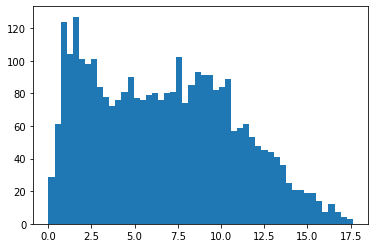

In [31]:
zz=plt.hist(ang_dist,bins=50)

In [47]:
#@title Tap Query String
tap_query_string = '\n'.join([
'select \tgs.source_id as Source ',
        '\t\t,gs.ra as RAdeg ',
        '\t\t,gs.dec as DEdeg ',
        '\t\t,gs.parallax as Plx ',
        '\t\t,gs.pmra as pmRA ',
        '\t\t,gs.pmdec as pmDE ',
        '\t\t,gs.phot_g_mean_mag as Gmag ',
        '\t\t,gs.phot_bp_mean_mag as BPmag ',
        '\t\t,gs.phot_rp_mean_mag as RPmag ',
        '\t\t,gd.r_est as rest ',
    'from gaiadr2.gaia_source gs ',
    '\tleft join gaiadr2_complements.geometric_distance gd using (source_id) ',
    'where ', 
          '\tCONTAINS(POINT(\'ICRS\', gs.ra, gs.dec), ',
              '\t\tCIRCLE(\'ICRS\', {ra}, {dec}, {rad})) = 1 '.format(ra=ra, dec=dec, rad=search_r),
      '\tand gd.r_est between {r_lo} and {r_hi}'.format(r_lo=med_dist*0.9, r_hi=med_dist*1.1),
      '\tand gs.parallax_over_error > 5.0'
])

print(tap_query_string)

select 	gs.source_id as Source 
		,gs.ra as RAdeg 
		,gs.dec as DEdeg 
		,gs.parallax as Plx 
		,gs.pmra as pmRA 
		,gs.pmdec as pmDE 
		,gs.phot_g_mean_mag as Gmag 
		,gs.phot_bp_mean_mag as BPmag 
		,gs.phot_rp_mean_mag as RPmag 
		,gd.r_est as rest 
from gaiadr2.gaia_source gs 
	left join gaiadr2_complements.geometric_distance gd using (source_id) 
where 
	CONTAINS(POINT('ICRS', gs.ra, gs.dec), 
		CIRCLE('ICRS', 52.074625695066345, 48.932707471347136, 17.6246967327452)) = 1 
	and gd.r_est between 165.15045 and 201.85055
	and gs.parallax_over_error > 5.0


In [48]:

#1. Import the relevant modules/classes/packages
from pyvo.dal import TAPService

#2. Query the ARI Gaia TAP Service
tap_service_url = "http://gaia.ari.uni-heidelberg.de/tap"
tap_service = TAPService(tap_service_url)
tap_results = tap_service.search(tap_query_string);

print(f'query returned {len(tap_results)} rows')

query returned 28685 rows


In [0]:
alpha_per.set_index('Source', inplace=True)

In [0]:
tap_df = tap_results.to_table().to_pandas()
tap_df.set_index('source', inplace=True)

In [0]:
import pickle
path = './gdrive/My Drive/cas-tau/data/tap_query.pkl'
with open(path,'wb') as pkl:
  pickle.dump(tap_df, pkl)


In [56]:
tap_df.head()

,radeg,dedeg,plx,pmra,pmde,gmag,bpmag,rpmag,rest
source,,,,,,,,,
216762910621557504,57.724542,31.839752,5.001295,-2.726881,-30.689681,17.566145,19.199448,16.031351,201.138437
216776968051779200,57.920635,31.922662,5.102463,5.721302,4.014477,13.595032,14.411274,12.714785,194.882810
216810984192641024,57.213933,31.894783,5.843610,23.298598,-41.769166,17.310120,19.057116,16.039265,170.474358
216442162463613184,56.641810,31.709988,5.931883,3.279264,-40.023735,19.815424,20.896929,18.330465,173.087409
216439349261434496,56.850610,31.718682,5.682356,32.390959,-20.722082,17.839262,19.715315,16.479885,175.519125


### Make Consolidated Data Frame

In [0]:
#need the colnames in lower case because that's what the tap query returns
alpha_per_lc = alpha_per.rename(columns = dict([(s,s.lower()) for s in alpha_per.columns]))

In [71]:
alpha_per_lc.head()

,radeg,dedeg,sourcecp,rvcp,e_rvcp,plxcp,e_plxcp,gmagcp,pmracp,e_pmracp,pmdecp,e_pmdecp,bx,by,bz,vx,vy,vz,c,distc,plx,e_plx,pmra,e_pmra,pmde,e_pmde,radecor,raplxcor,rapmracor,rapmdecor,deplxcor,depmracor,depmdecor,plxpmracor,plxpmdecor,pmrapmdecor,nal,nac,ngal,nbal,...,epsi,sepsi,solved,apf,wal,pscol,e_pscol,fvarpi,matchobsa,nper,amax,matchobs,dup,o_gmag,fg,e_fg,rfg,gmag,o_bpmag,fbp,e_fbp,rfbp,bpmag,o_rpmag,frp,e_frp,rfrp,rpmag,e(br/rp),mode,rv,e_rv,o_rv,rest,b_rest,b_rest,rlen,resflag,modflag,distancebin
Source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
455075360092433920,34.813290,52.493074,455075360092433920,-9999.0,-9999.0,5.77091,0.109942,16.5334,27.646,0.350,-19.901,0.181,-123.872,118.688,-24.409,-9999.0,-9999.0,-9999.0,0.420957,34.5058,5.7999,0.1099,27.646,0.350,-19.901,0.181,-0.2699,-0.5139,-0.8077,0.4042,0.0562,0.3804,-0.1491,0.5416,-0.1116,-0.3220,141,0,141,0,...,0.281,2.61,31,0,3.4993,1.2448,0.0191,-0.114,16,10,0.339762,19,0,166,4592.00,4.7807,960.526,16.5334,15,615.380,10.6550,57.758,18.378500,18,6480.10,18.5470,349.383,15.233000,1.545,0,0.0,0.0,0,171.669,168.464,174.996,827.580,1,1,Within 50.0 pc
455037048980464896,35.010252,52.664085,455037048980464896,-9999.0,-9999.0,5.63410,1.095480,20.3099,18.664,2.195,-20.069,1.896,-127.060,121.507,-24.384,-9999.0,-9999.0,-9999.0,13.234600,34.3879,5.6581,1.0955,18.664,2.195,-20.069,1.896,0.2736,-0.4405,-0.6056,-0.0620,-0.1343,-0.0219,0.3494,0.3507,0.3873,0.2143,115,0,113,2,...,1.942,2.12,31,0,0.0436,1.7967,0.2023,-0.008,14,9,2.102480,17,0,139,141.71,1.0618,133.458,20.3099,9,28.670,10.6950,2.681,21.707800,16,234.81,9.2633,25.348,18.835100,1.859,0,0.0,0.0,0,189.235,149.916,256.777,834.032,1,1,Within 50.0 pc
455026156947855872,35.076013,52.480215,455026156947855872,-9999.0,-9999.0,5.46087,1.454370,20.3340,21.394,3.404,-2.636,2.976,-131.260,125.082,-25.662,-9999.0,-9999.0,-9999.0,12.647600,35.1074,5.4758,1.4544,21.394,3.404,-2.636,2.976,0.3917,-0.0868,-0.5967,-0.1674,0.0537,-0.2249,-0.2459,0.2538,0.2781,0.2142,98,0,98,0,...,5.371,10.10,31,0,0.0186,1.3558,0.3260,-0.009,11,9,3.279610,15,1,125,138.59,1.3518,102.525,20.3340,11,51.996,5.1588,10.079,21.061501,14,188.02,18.8130,9.994,19.076401,1.732,0,0.0,0.0,0,211.700,126.050,725.565,828.804,1,1,Within 50.0 pc
355242590505237888,35.095645,48.516677,355242590505237888,-9999.0,-9999.0,5.89340,0.077502,15.8404,27.676,0.134,-19.837,0.128,-122.993,111.648,-34.630,-9999.0,-9999.0,-9999.0,0.767255,33.9603,5.9488,0.0775,27.676,0.134,-19.837,0.128,0.1752,0.2034,-0.5221,0.0501,-0.2183,-0.0538,-0.2104,0.0859,0.3614,0.1999,195,0,195,0,...,0.300,6.64,31,0,5.2357,1.2836,0.0156,-0.002,22,11,0.134695,24,0,213,8693.70,9.2816,936.664,15.8404,22,1552.200,10.2840,150.926,17.374001,22,11301.00,36.1090,312.962,14.629200,1.478,0,0.0,0.0,0,167.334,165.175,169.549,686.124,1,1,Within 50.0 pc
355343947436467200,35.202351,49.437643,355343947436467200,-9999.0,-9999.0,5.82667,0.286555,17.6887,36.234,0.626,-24.237,0.433,-124.281,113.835,-32.416,-9999.0,-9999.0,-9999.0,19.325500,33.2344,5.8477,0.2866,36.234,0.626,-24.237,0.433,-0.0121,-0.0533,-0.6749,0.1690,-0.1872,0.1828,0.0101,0.1676,0.2505,0.0145,143,0,143,0,...,1.149,14.90,31,0,0.4716,1.3067,0.0562,-0.038,17,10,0.575591,19,0,156,1584.40,7.5617,209.534,17.6887,13,341.910,10.0650,33.970,19.016600,12,2415.60,14.7320,163.971,16.304399,1.740,1,0.0,0.0,0,170.884,162.705,179.914,721.461,1,1,Within 50.0 pc


In [0]:
mycols = [s.lower() for s in ['radeg','DEdeg','Plx', 'pmRA', 'pmDE','Gmag','BPmag','RPmag','rest']]

consol_df=tap_df.merge(alpha_per_lc[mycols],how='outer',left_index=True, right_index=True,indicator=True)

In [91]:
consol_df._merge.value_counts()

left_only     26969
both           1716
right_only     1446
Name: _merge, dtype: int64

In [0]:
consol_df['which'] = consol_df._merge.apply(lambda s: 'lodieu' if s == 'right_only' else 'tap' if s == 'left_only' else 'both')
for c in mycols:
  consol_df[c]=np.where(np.isnan(consol_df[c+'_x']), consol_df[c+'_y'], consol_df[c+'_x'])

consol_df.drop(columns = [s+'_x' for s in mycols]+[s+'_y' for s in mycols], inplace=True)

In [93]:
consol_df.which.value_counts()

tap       26969
both       1716
lodieu     1446
Name: which, dtype: int64

In [94]:
consol_df.query('which == \'lodieu\'').head()

,_merge,which,radeg,dedeg,plx,pmra,pmde,gmag,bpmag,rpmag,rest
142839204833313408,right_only,lodieu,45.528660,39.168667,5.5849,7.028,-16.292,20.7358,21.193600,19.559299,580.823
142942627646175104,right_only,lodieu,45.778371,39.477138,5.3342,6.980,-12.677,20.7254,21.044701,20.805799,407.573
143481701875966592,right_only,lodieu,43.921781,39.802850,5.7946,12.688,-9.771,20.4017,21.095699,19.008400,215.083
143595707487785856,right_only,lodieu,45.358971,39.384358,5.6180,5.195,-6.908,20.9837,20.517200,19.780300,834.562
143690712164105728,right_only,lodieu,44.899103,40.114218,5.7505,9.647,-12.088,20.4038,21.398399,19.030100,215.054


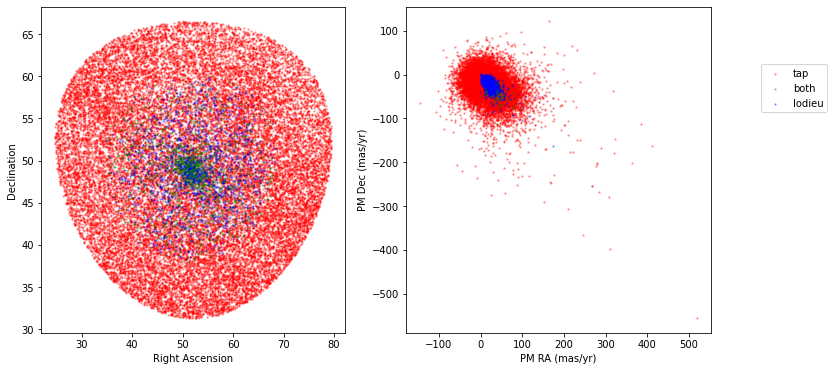

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for s,c in zip(['tap','both','lodieu',],['red','green','blue']):
  pdf = consol_df.query('which == @s')
  ax[0].scatter(pdf.radeg, pdf.dedeg, color=c, label=s, s=2, alpha=0.3)
#ax[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[0].set_xlabel('Right Ascension')
_=ax[0].set_ylabel('Declination')

for s,c in zip(['tap','both','lodieu'],['red','green','blue']):
  pdf = consol_df.query('which == @s')
  ax[1].scatter(pdf.pmra, pdf.pmde, color=c, label=s, s=2, alpha=0.3)
ax[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.75))
ax[1].set_xlabel('PM RA (mas/yr)')
_=ax[1].set_ylabel('PM Dec (mas/yr)')


In [89]:
consol_df.query('which == \'lodeiu\'').head()

,_merge,which,radeg,dedeg,plx,pmra,pmde,gmag,bpmag,rpmag,rest
142839204833313408,right_only,lodeiu,45.528660,39.168667,5.5849,7.028,-16.292,20.7358,21.193600,19.559299,580.823
142942627646175104,right_only,lodeiu,45.778371,39.477138,5.3342,6.980,-12.677,20.7254,21.044701,20.805799,407.573
143481701875966592,right_only,lodeiu,43.921781,39.802850,5.7946,12.688,-9.771,20.4017,21.095699,19.008400,215.083
143595707487785856,right_only,lodeiu,45.358971,39.384358,5.6180,5.195,-6.908,20.9837,20.517200,19.780300,834.562
143690712164105728,right_only,lodeiu,44.899103,40.114218,5.7505,9.647,-12.088,20.4038,21.398399,19.030100,215.054


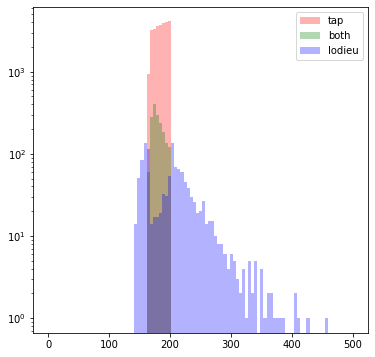

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for s,c in zip(['tap','both','lodieu',],['red','green','blue']):
  pdf = consol_df.query('which == @s')
  ax.set_yscale('log')
  ax.hist(pdf.rest,bins=np.linspace(0,500,100, endpoint=True), color=c, label=s,  alpha=0.3)
ax.legend()

In [108]:
consol_df.query('rest >= 165.15045  and rest <=201.85055').which.value_counts()

tap       26969
both       1716
lodieu      176
Name: which, dtype: int64

In [133]:
#build balanced data frame
members = consol_df.query('which==\'both\'')
n_both = len(members)
non_members = consol_df.query('which==\'tap\'').sample(n=n_both, random_state=1234)
balanced_df = pd.concat([members, non_members])

#shuffle it up
np.random.seed(4321)
balanced_df = balanced_df.loc[np.random.permutation(balanced_df.index)]

#ditch rows with NaNs
balanced_df.dropna(inplace=True)

#binary value for candidacy
balanced_df['candidate'] = np.where(balanced_df.which == 'both', 1, 0)

balanced_df.which.value_counts()

both      1716
tap       1685
lodieu       0
Name: which, dtype: int64

In [134]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3401 entries, 262694356038071424 to 432459741638340224
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   _merge     3401 non-null   category
 1   which      3401 non-null   category
 2   radeg      3401 non-null   float64 
 3   dedeg      3401 non-null   float64 
 4   plx        3401 non-null   float64 
 5   pmra       3401 non-null   float64 
 6   pmde       3401 non-null   float64 
 7   gmag       3401 non-null   float64 
 8   bpmag      3401 non-null   float64 
 9   rpmag      3401 non-null   float64 
 10  rest       3401 non-null   float64 
 11  candidate  3401 non-null   int64   
dtypes: category(2), float64(9), int64(1)
memory usage: 299.1 KB


In [135]:
np.any(balanced_df.gmag==-9999.0)

False

In [136]:
# partition to train, val and test dataframes
test_frac = 0.2; train_frac = 0.65; val_frac = 1.0 - test_frac - train_frac
nrows = len(balanced_df)
test_n = int(test_frac*nrows); train_n=int(train_frac*nrows); val_n=nrows-test_n-train_n

train_df = balanced_df.iloc[:train_n]
val_df = balanced_df.iloc[train_n:train_n+val_n]
test_df = balanced_df.iloc[train_n+val_n:]

len(train_df), len(val_df), len(test_df), nrows

(2210, 511, 680, 3401)

# Classifier Models

In [0]:
# some needed libraries
from sklearn.model_selection import train_test_split # to partition the dataset into training and test
from sklearn.metrics import accuracy_score, confusion_matrix # for model evaluation
from sklearn.linear_model import LogisticRegression # classifier model to test

In [0]:
# function to create features from input data set
# returns (n,4) feature matrix and (n,) label vector
def get_features_labels(df):
    features = np.zeros((len(df), 5))
    features[:,0] = np.array(df.pmra)
    features[:,1] = np.array(df.pmde)
    features[:,2] = np.array(df.bpmag - df.gmag)
    features[:,3] = np.array(df.gmag - df.rpmag)
    features[:,4] = np.array(np.sqrt(df.pmra**2+df.pmde**2))
    labels = np.array(df.candidate)
    return features, labels

In [0]:
#get the features and labels for each of the sets
x_train,  y_train  = get_features_labels(train_df)
x_val,  y_val  = get_features_labels(val_df)
x_test, y_test = get_features_labels(test_df)

## Logit Classifier

In [150]:
logit_model = LogisticRegression()
logit_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [151]:
# calculate prediction accuracy on the dev set
pred_ovr_train = logit_model.predict(x_train)
acc_ovr_train = accuracy_score(y_train, pred_ovr_train)

#calculate prediction accuracy on the validation set
pred_ovr_val = logit_model.predict(x_val)
acc_ovr_val = accuracy_score(y_val, pred_ovr_val)

print('OVR Training Set Accuracy: ', acc_ovr_train)
print('OVR Validation Set Accuracy: ', acc_ovr_val)

OVR Training Set Accuracy:  0.8289592760180996
OVR Validation Set Accuracy:  0.821917808219178


In [152]:
confusion_matrix(y_val, pred_ovr_val)

array([[172,  79],
       [ 12, 248]])

In [153]:
logit_model.classes_

array([0, 1])

## K Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [159]:
neighbors = KNeighborsClassifier()
neighbors.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [161]:
# calculate prediction accuracy on the dev set
pred_knn_train = neighbors.predict(x_train)
acc_knn_train = accuracy_score(y_train, pred_knn_train)

#calculate prediction accuracy on the validation set
pred_knn_val = neighbors.predict(x_val)
acc_knn_val = accuracy_score(y_val, pred_knn_val)

print('KNN Training Set Accuracy: ', acc_knn_train)
print('KNN Validation Set Accuracy: ', acc_knn_val)

KNN Training Set Accuracy:  0.9104072398190045
KNN Validation Set Accuracy:  0.8904109589041096


In [162]:
confusion_matrix(y_val, pred_knn_val)

array([[219,  32],
       [ 24, 236]])

## Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [166]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [167]:
# calculate prediction accuracy on the dev set
pred_dtc_train = dtc.predict(x_train)
acc_dtc_train = accuracy_score(y_train, pred_dtc_train)

#calculate prediction accuracy on the validation set
pred_dtc_val = dtc.predict(x_val)
acc_dtc_val = accuracy_score(y_val, pred_dtc_val)

print('DTC Training Set Accuracy: ', acc_dtc_train)
print('DTC Validation Set Accuracy: ', acc_dtc_val)

DTC Training Set Accuracy:  1.0
DTC Validation Set Accuracy:  0.8825831702544031


## Ensemble

In [0]:
def ensemble(modlist, X):
  """
  only works for binary classifiers
  """
  thresh = np.ceil(len(modlist)/2.0)
  yhat = np.array([m.predict(X) for m in modlist])
  yhat_ens = np.where(yhat.sum(axis=0)>=thresh,1,0)
  return yhat_ens


In [0]:
modlist = [logit_model, neighbors, dtc]

In [197]:
# calculate prediction accuracy on the dev set
pred_ens_train = ensemble(modlist, x_train)
acc_ens_train = accuracy_score(y_train, pred_ens_train)

#calculate prediction accuracy on the validation set
pred_ens_val = ensemble(modlist, x_val)
acc_ens_val = accuracy_score(y_val, pred_ens_val)

print('ENS Training Set Accuracy: ', acc_ens_train)
print('ENS Validation Set Accuracy: ', acc_ens_val)

ENS Training Set Accuracy:  0.9443438914027149
ENS Validation Set Accuracy:  0.9001956947162426


In [198]:
confusion_matrix(y_val, pred_ens_val)

array([[215,  36],
       [ 15, 245]])

In [0]:
confusion = pd.DataFrame([confusion_matrix(y_val, pred_ovr_val).flatten(),
                          confusion_matrix(y_val, pred_knn_val).flatten(),
                          confusion_matrix(y_val, pred_dtc_val).flatten(),
                          confusion_matrix(y_val, pred_ens_val).flatten()],
                    index=['LogitRegr','KNN', 'DTC', 'Ens'],
                    columns = ['Tpos','Fneg','Fpos','Tneg'])

In [200]:
confusion

,Tpos,Fneg,Fpos,Tneg
LogitRegr,172,79,12,248
KNN,219,32,24,236
DTC,216,35,25,235
Ens,215,36,15,245


In [195]:
acc_ens_train.shape, pred_dtc_train.shape

((2210,), (2210,))

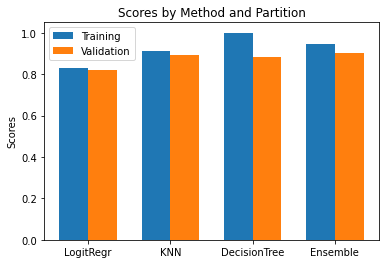

In [201]:
train_acc = (acc_ovr_train, acc_knn_train, acc_dtc_train, acc_ens_train)
val_acc = (acc_ovr_val, acc_knn_val, acc_dtc_val, acc_ens_val)

ind = np.arange(len(train_acc))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train_acc, width, 
                label='Training')
rects2 = ax.bar(ind + width/2, val_acc, width, 
                label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Method and Partition')
ax.set_xticks(ind)
ax.set_xticklabels(('LogitRegr', 'KNN', 'DecisionTree', 'Ensemble'))
ax.legend()

# Old Stuff

In [0]:
def get_stars(ra, dec, rad=2.0*u.degree):
    query_text = "SELECT  \
                random_index, ra, dec, parallax, pmra, pmdec, radial_velocity,\
                phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_val, radius_val, lum_val \
                FROM gaiadr2.gaia_source \
            WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec), \
                    CIRCLE('ICRS',{ra},{dec},{rad}))=1 \
                    and parallax_over_error > 5 ".format(ra=ra.value, dec=dec.value, rad=rad.value)
                    #--AND abs(pmra_error/pmra)<0.10 \
                    #--AND abs(pmdec_error/pmdec)<0.10 \
                    #--AND pmra IS NOT NULL AND abs(pmra)>0 \
                    #--AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                    #--and parallax IS NOT NULL and parallax > 0".format(ra=ra.value, dec=dec.value, rad=rad.value)
    
    job = Gaia.launch_job_async(query_text)
    gaia_data = job.get_results()

    result_dict = {}
    result_dict['dist'] = coord.Distance(parallax=u.Quantity(gaia_data['parallax']),allow_negative=True)
    result_dict['coord']=  coord.SkyCoord(ra=gaia_data['ra'],
                   dec=gaia_data['dec'],
                   distance=result_dict['dist'],
                   pm_ra_cosdec=gaia_data['pmra'],
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])
    result_dict['M_G'] = gaia_data['phot_g_mean_mag'] - result_dict['dist'].distmod
    result_dict['BP_RP'] = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']
    
    result_dict['data'] = gaia_data.to_pandas()

    return result_dict

In [0]:
#don't execute this query
#clust = get_stars(alf_per.ra, alf_per.dec)

In [0]:
#nor this
#len(clust['data'])

In [0]:
# the file colnames.txt extracted from Readme.txt that came with the archive.  Provides column names for the alpha_per and pleiades data sets
colnames_txt_path = './gdrive/My Drive/cas-tau/Cass-Tau/data/J_A+A_628_A66/colnames.txt'
with open(colnames_txt_path,'r') as f:
    colnames_txt = f.readlines()
colnames = [s.strip() for s in colnames_txt]
colnames = [s for s in colnames if s] #ditch the blanks

In [0]:
# read up the two data files
path = './gdrive/My Drive/cas-tau/Cass-Tau/data/J_A+A_628_A66/alphaper.dat'
alpha_per = pd.read_csv(path, delim_whitespace=True, error_bad_lines=False, warn_bad_lines=True,
                        header=None,usecols=range(len(colnames)), names=colnames)
path = './gdrive/My Drive/cas-tau/Cass-Tau/data/J_A+A_628_A66/pleiades.dat'
pleiades = pd.read_csv(path, delim_whitespace=True, error_bad_lines=False, warn_bad_lines=True,
                        header=None,usecols=range(len(colnames)), names=colnames)

In [0]:
alpha_per.info()

In [0]:
(alpha_per.RVCP==-9999.0).sum()/len(alpha_per)

0.9468690702087287

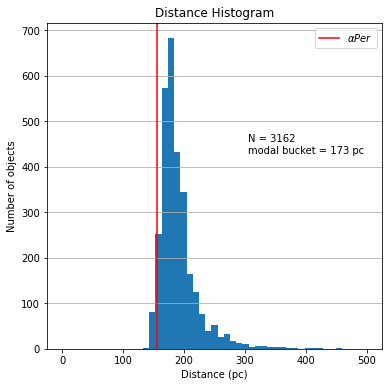

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
zz=ax.hist(alpha_per.rest,bins=np.linspace(0,500,50, endpoint=True))
ax.set_ylabel('Number of objects')
un = u.parsec
ax.set_xlabel(f'Distance ({un})')
ax.set_title('Distance Histogram')
N = len(alpha_per)
mode = zz[1][zz[0].argmax()]
ax.text(0.60, 0.60,f'N = {N}\nmodal bucket = {mode:.0f} pc',transform=ax.transAxes)
ax.grid(axis='y')
ax.axvline(alf_per_dist, color='red',label=r'$\alpha Per$')
ax.legend()

In [0]:
clust['data'].head()

,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,teff_val,radius_val,lum_val
0,98502889,52.629896,48.400698,0.555772,-0.040482,-2.529465,NaN,15.837806,16.379410,15.137469,4905.259766,1.552596,1.257360
1,1679413159,52.819404,48.339305,0.659641,11.593670,-6.446418,NaN,17.215570,17.924007,16.407282,NaN,NaN,NaN
2,164126142,52.593901,48.411372,5.276509,21.371321,-23.586307,NaN,13.655598,14.465488,12.779420,4300.180176,0.648345,0.129495
3,789045382,52.578474,48.415945,1.216534,13.882647,-14.050392,NaN,15.361196,15.953802,14.633895,4787.290039,0.942034,0.419940
4,92168801,52.388265,48.145011,1.629728,9.635025,-12.726669,NaN,14.362868,14.900310,13.678874,4861.205078,1.069235,0.575197


Text(0.5, 0, 'Right Ascension')

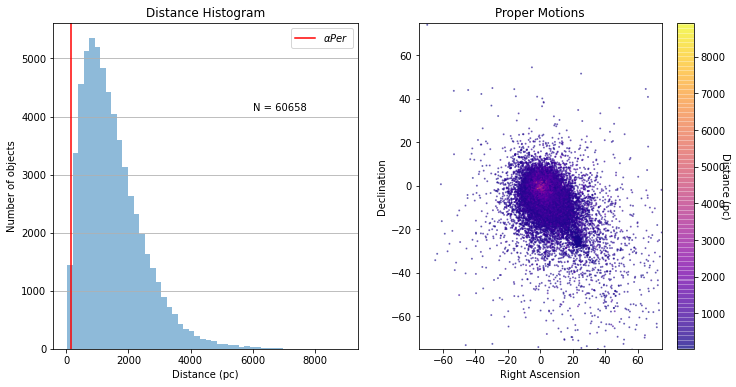

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

zz=ax[0].hist(np.array(clust['dist']),bins=50, alpha=0.5)
ax[0].set_ylabel('Number of objects')
un = clust['dist'][0].unit
ax[0].set_xlabel(f'Distance ({un})')
ax[0].set_title('Distance Histogram')
N = len(clust['data'])
ax[0].text(6000,4100,f'N = {N}')
ax[0].grid(axis='y')
ax[0].axvline(155, color='red',label=r'$\alpha Per$')
ax[0].legend()


pcm=ax[1].scatter(clust['data'].pmra, clust['data'].pmdec, s=1., alpha=0.5,
           c = clust['dist'],
           cmap='plasma')

un = clust['dist'][0].unit

cbar = fig.colorbar(pcm)
cbar.set_label(f'Distance ({un})', rotation=270)
ax[1].set_xlim(-75,75)
ax[1].set_ylim(-75,75)
ax[1].set_title('Proper Motions')
ax[1].set_ylabel('Declination')
ax[1].set_xlabel('Right Ascension')

Text(0.5, 1.0, 'HR Diagram')

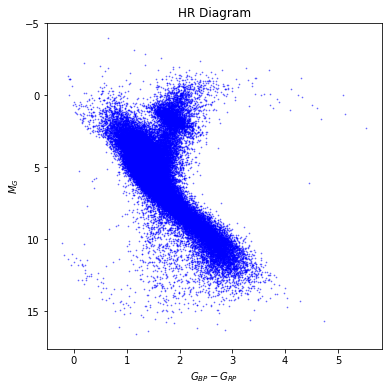

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pcm = ax.scatter(clust['BP_RP'], clust['M_G'],
        marker='.', alpha=0.5,c = 'blue', s=2) #,
           #cmap='plasma_r', norm=colors.PowerNorm(gamma=0.5,vmin=gaia_data_r['teff_val'].min(), vmax=gaia_data_r['teff_val'].max()))

#ax.set_xlim(0, 3)
#ax.set_ylim(11, 1)
ax.invert_yaxis()

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
ax.set_title('HR Diagram')
#cbar = fig.colorbar(pcm)
#cbar.ax.set_ylabel( 'Effective Temperature (K)', rotation=270)